In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.tsa.stattools as sts

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import time

# Processing

In [2]:
path = 'GOOGL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(path)

In [3]:
# Converting Date column to datetime
df['Date'] = pd.to_datetime(df.Date, yearfirst=True)

In [4]:
df.set_index('Date', inplace=True) # Setting the index to date

df = df.asfreq('b') # Setting the frequency to business days

df.drop('Name', axis=1, inplace=True) # Dropping useless columns

# Checking clusters of NaN and filling NaN

In [5]:
df = df.fillna(method='bfill') # Backfilling

# Adding the other samples
df = df.asfreq('b')
df = df.fillna(method='ffill') # Sampling them using frontfill

<ipython-input-5-4844ccfb08b8>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill') # Backfilling
<ipython-input-5-4844ccfb08b8>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill') # Sampling them using frontfill


# Normalization

In [6]:
train_size = 0.8
val_size = 0.1
train_samples = int(df.shape[0]*train_size)
val_samples = int(df.shape[0]*(train_size+val_size))

scaler = StandardScaler()
df.iloc[:train_samples] = scaler.fit_transform(df.iloc[:train_samples])
df.iloc[train_samples:] = scaler.transform(df.iloc[train_samples:])

# Transformer

In [7]:
# Fixing open variable
df = df.shift(-1).iloc[:-1]

In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

def floatation(df, attributes):
    for var in attributes:
        df[var] = df[var].astype(str)            # converting to string
        df[var] = df[var].str.replace(',', '.')  # replacing the commas with dot decimal separatpr
        df[var] = df[var].astype(np.float32)     # converting the values into dot
    return df

def sequencing(dataset, start_index=0, end_index=None, history_size=50, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

def partition(data, pTrain=0.7, pVal = 0.5, save_path=None):
    # Data is already normalized
    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=50, step=1)

    dataTrain = sequencedData[:train_samples]
    dataVal = sequencedData[train_samples:val_samples]
    dataTest = sequencedData[val_samples:]

    return dataTrain, dataVal, dataTest

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def split(trainData, predicting_window):
    # Adapting targets to have a predicting window > 1
    targets = trainData[:, predicting_window:, :].tolist()
    for i in range(len(targets)): # samples dim
        for k in range(1, trainData.shape[1]-predicting_window+1):
            targets[i][k-1] = trainData[i, k:k+predicting_window, 3]
    targets = np.array(targets)
    trainData = trainData[:, :-predicting_window, :]

    inputs = torch.tensor(trainData, device=device)
    targets = torch.tensor(targets, device=device)
    return inputs, targets

def createLoaders(dataTrain, dataVal, dataTest, predicting_window, batchSize=32):
    XTrain, YTrain = split(dataTrain, predicting_window)
    XVal, YVal = split(dataVal, predicting_window)
    XTest, YTest = split(dataTest, predicting_window)

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=50, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)


class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)


Training Loss: 0.05327416251448891
Validation Loss: 0.42134469747543335
Test Loss: 3.343734774324629
Training time: 75.779714345932


Text(0.5, 1.0, 'Transformer Loss')

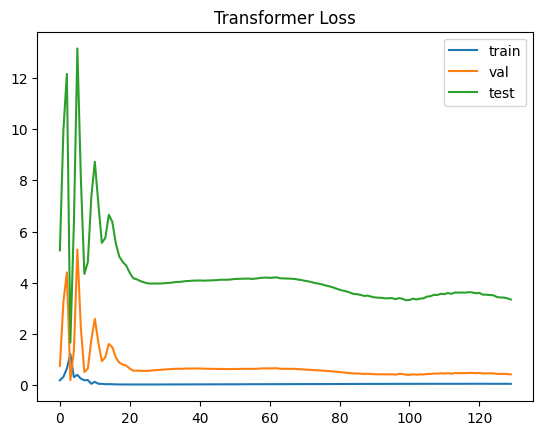

In [9]:
layer = 1
my_D = 256
my_H = 4
hidden = 96
t0 = time.time()
transformer = Transformer(num_layers=layer, D=my_D, H=my_H, hidden_mlp_dim=hidden,
                          inp_features=5, out_features=1, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(),
                                lr=0.00001)


n_epochs = 130
attributes = list(df.columns)
df1 = floatation(df, attributes)
data = df1.values
losses, val_losses, test_losses = [], [],[]
trainData, valData, testData = partition(data)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData, predicting_window=1)
niter = len(trainDataset)

y_train_arr = []
y_pred_train = []

y_val_arr = []
y_pred_val = []

y_test_arr = []
y_pred_test = []

for e in range(n_epochs):

    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if e == n_epochs-1:
            y_train_arr.append(y[:, -1, 0])
            y_pred_train.append(out[:, -1, 0])
    losses.append(sum_train_loss / niter)

    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(valDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
        if e == n_epochs-1:
            y_val_arr.append(y[:, -1, 0])
            y_pred_val.append(out[:, -1, 0])

    val_losses.append(sum_val_loss / (i + 1))
    transformer.eval()
    sum_test_loss = 0.0
    for i, (x, y) in enumerate(testDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_test_loss += loss.item()

        if e == n_epochs-1:
            y_test_arr.append(y[:, -1, 0])
            y_pred_test.append(out[:, -1, 0])
    test_losses.append(sum_test_loss / (i + 1))



print("Training Loss:", losses[-1]), print("Validation Loss:", val_losses[-1]), print("Test Loss:", test_losses[-1])
transformer_training_time = time.time()-t0
print("Training time:", transformer_training_time)
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.plot(test_losses, label='test')
plt.legend()
plt.title("Transformer Loss")

In [10]:
aux = []
[aux.extend(x) for x in y_train_arr]
y_train_arr = np.array([x.cpu() for x in aux])

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_train]
y_pred_train = np.array(aux)


aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_val_arr]
y_val_arr = np.array(aux)

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_val]
y_pred_val = np.array(aux)


aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_test_arr]
y_test_arr = np.array(aux)

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_test]
y_pred_test = np.array(aux)


mean = scaler.mean_[3]
std = np.sqrt(scaler.var_[3])

y_train_arr = y_train_arr * std + mean
y_pred_train = y_pred_train * std + mean
y_val_arr = y_val_arr * std + mean
y_pred_val = y_pred_val * std + mean
y_test_arr = y_test_arr * std + mean
y_pred_test = y_pred_test * std + mean

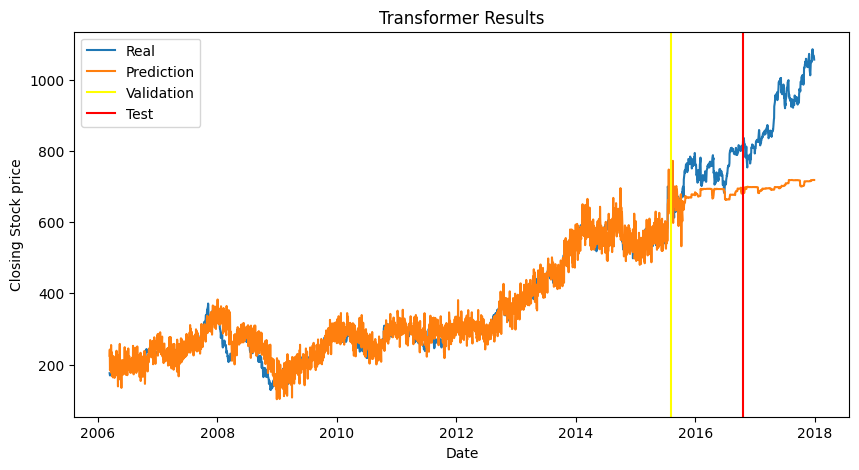

In [11]:
plt.subplots(figsize=(10, 5))

plt.plot(df.index[50:], np.concatenate([y_train_arr, y_val_arr, y_test_arr]), label='Real')
plt.plot(df.index[50:], np.concatenate([y_pred_train, y_pred_val, y_pred_test]), label='Prediction')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("Transformer Results")
plt.show()

In [12]:
# Getting metrics
# MSE
train_rmse_transformer = np.sqrt( mean_squared_error( y_train_arr, y_pred_train ) )
val_rmse_transformer = np.sqrt( mean_squared_error( y_val_arr, y_pred_val ) )
test_rmse_transformer = np.sqrt( mean_squared_error( y_test_arr, y_pred_test ) )

# MAE
train_mae_transformer = mean_absolute_error(  y_train_arr, y_pred_train  )
val_mae_transformer = mean_absolute_error( y_val_arr, y_pred_val )
test_mae_transformer = mean_absolute_error( y_test_arr, y_pred_test )

# Results

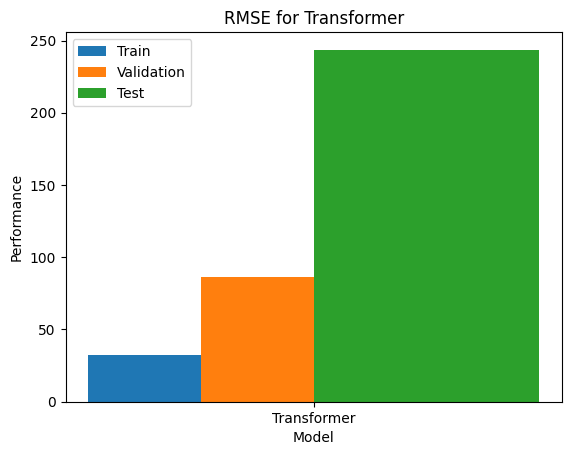

In [13]:
# RMSE Results for Transformer
x_arr = np.array([0])  # Only one model
plt.bar(x_arr - 0.1, [train_rmse_transformer], label='Train', width=0.2)
plt.bar(x_arr, [val_rmse_transformer], label='Validation', width=0.2)
plt.bar(x_arr + 0.1, [test_rmse_transformer], label='Test', width=0.2)

# Plot Customization
plt.xticks(x_arr, ['Transformer'])
plt.xlabel("Model")
plt.ylabel("Performance")
plt.title("RMSE for Transformer")
plt.legend()
plt.show()


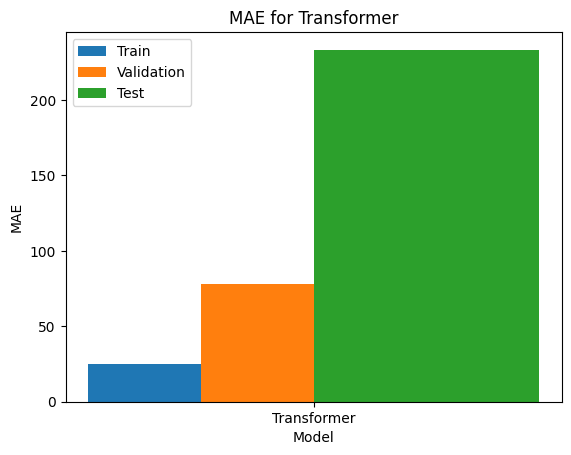

In [14]:
# MAE Results for Transformer
x_arr = np.array([0])  # Only one model
plt.bar(x_arr - 0.1, [train_mae_transformer], label='Train', width=0.2)
plt.bar(x_arr, [val_mae_transformer], label='Validation', width=0.2)
plt.bar(x_arr + 0.1, [test_mae_transformer], label='Test', width=0.2)

# Plot Customization
plt.xticks(x_arr, ['Transformer'])
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("MAE for Transformer")
plt.legend()
plt.show()


Longterm Transformer


In [15]:
layer = 1
my_D = 256
my_H = 4
hidden = 500


total_train_rmse = []
total_val_rmse = []
total_test_rmse = []
total_train_mae = []
total_val_mae = []
total_test_mae = []

total_time = []

for predicting_window in range(1, 32):
    t0 = time.time()
    transformer = Transformer(num_layers=layer, D=my_D, H=my_H, hidden_mlp_dim=hidden,
                              inp_features=5, out_features=predicting_window, dropout_rate=0.1).to(device)
    optimizer = torch.optim.RMSprop(transformer.parameters(),
                                    lr=0.00001)


    n_epochs = 130
    attributes = list(df.columns)
    df1 = floatation(df, attributes)
    data = df1.values
    losses, val_losses, test_losses = [], [],[]
    trainData, valData, testData = partition(data)
    trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData, predicting_window)
    niter = len(trainDataset)

    train_mse = []
    test_mse = []
    val_mse = []

    train_mae = []
    test_mae = []
    val_mae = []

    for e in range(n_epochs):
        # one epoch on train set
        transformer.train()
        sum_train_loss = 0.0
        for x,y in trainDataset:
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            if e == n_epochs-1:
                train_mse.append(torch.nn.MSELoss()(out*std+mean, y*std+mean))
                train_mae.append(torch.nn.L1Loss()(out*std+mean, y*std+mean))

        losses.append(sum_train_loss / niter)

        # Evaluate on val set
        transformer.eval()
        sum_val_loss = 0.0
        for i, (x, y) in enumerate(valDataset):
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_val_loss += loss.item()
            if e == n_epochs-1:
                val_mse.append(torch.nn.MSELoss()(out*std+mean, y*std+mean))
                val_mae.append(torch.nn.L1Loss()(out*std+mean, y*std+mean))

        val_losses.append(sum_val_loss / (i + 1))
        transformer.eval()
        sum_test_loss = 0.0
        for i, (x, y) in enumerate(testDataset):
            S = x.shape[1]
            mask = create_look_ahead_mask(S)
            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_test_loss += loss.item()

            if e == n_epochs-1:
                test_mse.append(torch.nn.MSELoss()(out*std+mean, y*std+mean))
                test_mae.append(torch.nn.L1Loss()(out*std+mean, y*std+mean))
        test_losses.append(sum_test_loss / (i + 1))



    total_train_rmse.append(np.mean(np.sqrt([x.cpu().detach() for x in train_mse])))
    total_test_rmse.append(np.mean(np.sqrt([x.cpu().detach() for x in test_mse])))
    total_val_rmse.append(np.mean(np.sqrt([x.cpu().detach() for x in val_mse])))
    total_time.append(time.time()-t0)

    total_train_mae.append(np.mean([x.cpu().detach() for x in train_mae]))
    total_test_mae.append(np.mean([x.cpu().detach() for x in test_mae]))
    total_val_mae.append(np.mean([x.cpu().detach() for x in val_mae]))

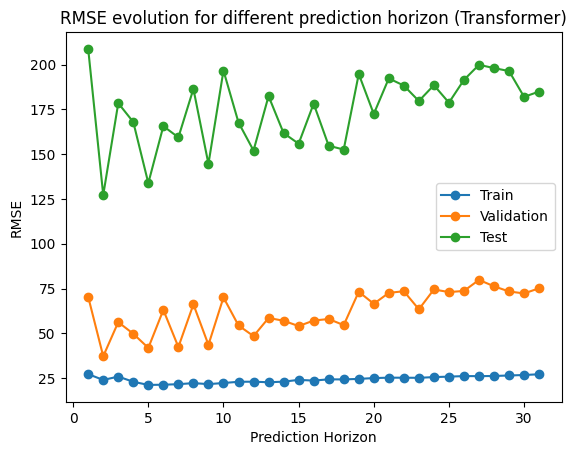

In [16]:

x_ticks = range(1, 32)
plt.plot(x_ticks, total_train_rmse, '-o', label='Train')
plt.plot(x_ticks, total_val_rmse, '-o', label='Validation')
plt.plot(x_ticks, total_test_rmse, '-o', label='Test')

plt.title("RMSE evolution for different prediction horizon (Transformer)")
plt.xlabel("Prediction Horizon")
plt.ylabel("RMSE")
plt.legend()
plt.show()

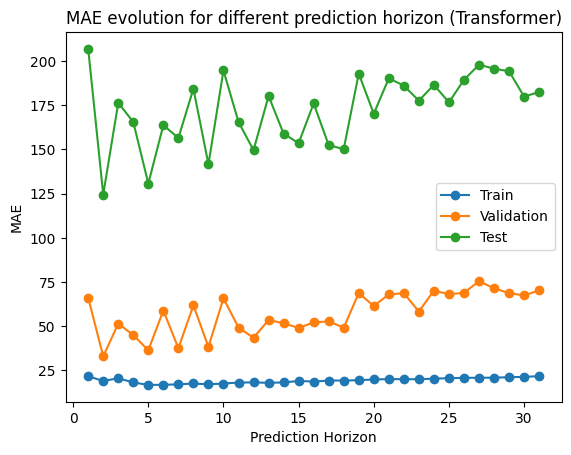

In [17]:

x_ticks = range(1, 32)
plt.plot(x_ticks, total_train_mae, '-o', label='Train')
plt.plot(x_ticks, total_val_mae, '-o', label='Validation')
plt.plot(x_ticks, total_test_mae, '-o', label='Test')

plt.title("MAE evolution for different prediction horizon (Transformer)")
plt.xlabel("Prediction Horizon")
plt.ylabel("MAE")
plt.legend()
plt.show()